In [1]:
from affine import *
from common import *
from conditions import *
from cycle import *

In [2]:
# a_vec = generate_random_a_vec()
a_vec = np.array([221, 101, 217, 199, 169, 343])
# b_vec = np.array([358, 314, 92, 303, 324, 375])

In [3]:
g_a = np.array([
    [1-a_vec[3], 0, 0, a_vec[0]-1, 0, 0],
    [1-a_vec[4], 0, 0, 0, a_vec[0]-1, 0],
    [1-a_vec[5], 0, 0, 0, 0, a_vec[0]-1],
    [0, 1-a_vec[3], 0, a_vec[1]-1, 0, 0],
    [0, 1-a_vec[4], 0, 0, a_vec[1]-1, 0],
    [0, 1-a_vec[5], 0, 0, 0, a_vec[1]-1],
    [0, 0, 1-a_vec[3], a_vec[2]-1, 0, 0],
    [0, 0, 1-a_vec[4], 0, a_vec[2]-1, 0],
    [0, 0, 1-a_vec[5], 0, 0, a_vec[2]-1],
])
g_bf = np.array([
    [1-a_vec[1], a_vec[0]-1, 0, 0, 0, 0],
    [1-a_vec[2], 0, a_vec[0]-1, 0, 0, 0],
    [0, 1-a_vec[2], a_vec[1]-1, 0, 0, 0],
])
g_bg = np.array([
    [0, 0, 0, 1-a_vec[4], a_vec[3]-1, 0],
    [0, 0, 0, 1-a_vec[5], 0, a_vec[3]-1],
    [0, 0, 0, 0, 1-a_vec[5], a_vec[4]-1],
])

行列方程式の解空間の基底を算出する関数

In [4]:
import numpy as np
from sympy import Matrix, eye

def get_null_space_basis_mod_p_fixed(M_np, P):
    m, n = M_np.shape
    # [M | -P*I] を作成
    big_mat = np.hstack([M_np, -P * np.eye(m, dtype=int)])
    sympy_mat = Matrix(big_mat)
    kernel_basis = sympy_mat.nullspace()
    
    bases = []
    for v in kernel_basis:
        # 【修正点】ベクトルの「全成分」の分母からLCMを計算する
        denominators = [x.q for x in v]
        import math
        lcm = 1
        for d in denominators:
            lcm = (lcm * d) // math.gcd(lcm, d)
        
        # 全体にLCMを掛けて整数化
        v_int = (v * lcm)
        # 最初の n 成分（bの分）を取り出して mod P
        b_int = np.array(v_int[:n]).flatten().astype(int) % P
        
        if np.any(b_int != 0):
            bases.append(b_int)
    return bases

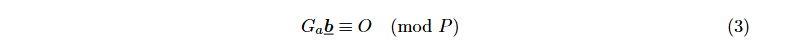

条件aを満たす$\bm{b}$の解空間

In [5]:
basis_a = get_null_space_basis_mod_p_fixed(g_a, P)
for i, v in enumerate(basis_a):
    print(f"v_{i} = {v}")

v_0 = [110  50 108  99  84 171]
v_1 = [320   0   0   0   0   0]
v_2 = [  0 320   0   0   0   0]
v_3 = [ 0  0  0 96  0  0]
v_4 = [ 0  0  0  0 96  0]
v_5 = [  0   0   0 288   0   0]


条件bを満たすために避けなければならない$\bm{c}$の空間

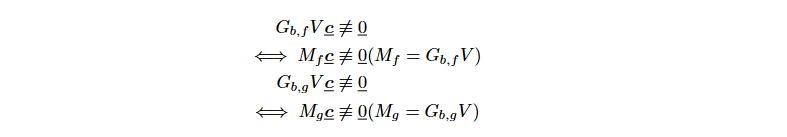

In [6]:
v_mat = np.array(basis_a).T
m_f = (g_bf @ v_mat) % P
m_g = (g_bg @ v_mat) % P

In [7]:
basis_bf = get_null_space_basis_mod_p_fixed(m_f, P)
basis_bg = get_null_space_basis_mod_p_fixed(m_g, P)

In [8]:
for i, v in enumerate(basis_bf):
    print(f"cfv_{i} = {v}")
for i, v in enumerate(basis_bg):
    print(f"cgv_{i} = {v}")

cfv_0 = [1 0 0 0 0 0]
cfv_1 = [  0 383   2   0   0   0]
cfv_2 = [0 0 0 1 0 0]
cfv_3 = [0 0 0 0 1 0]
cfv_4 = [0 0 0 0 0 1]
cfv_5 = [0 3 0 0 0 0]
cgv_0 = [1 0 0 0 0 0]
cgv_1 = [0 1 0 0 0 0]
cgv_2 = [0 0 1 0 0 0]
cgv_3 = [  0   0   0 383   0   1]
cgv_4 = [0 0 0 2 0 0]
cgv_5 = [0 0 0 0 2 0]


In [9]:
def inv(val):
    try:
        return pow(int(val), -1, P)
    except ValueError:
        raise ValueError("Inverse does not exist")

長さ4のサイクルがすべてCBCでない条件

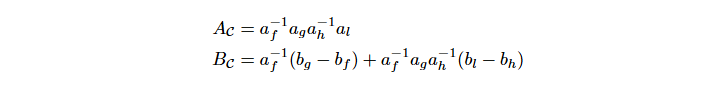

In [10]:
h_x_funcs = [
    [0,1,2,3,4,5],
    [2,0,1,5,3,4]
]
h_z_funcs = [
    [3,5,4,0,2,1],
    [4,3,5,1,0,2]
]

長さ4のサイクル

In [ ]:
def get_funcidx_4(cols):
    func_idx_x = []
    func_idx_x.append(h_x_funcs[0][cols[0]])
    func_idx_x.append(h_x_funcs[0][cols[1]])
    func_idx_x.append(h_x_funcs[1][cols[1]])
    func_idx_x.append(h_x_funcs[1][cols[0]])
    func_idx_z = []
    func_idx_z.append(h_z_funcs[0][cols[0]])
    func_idx_z.append(h_z_funcs[0][cols[1]])
    func_idx_z.append(h_z_funcs[1][cols[1]])
    func_idx_z.append(h_z_funcs[1][cols[0]])
    return [func_idx_x, func_idx_z]

def get_cycle_mat_4(funcidx):
    idx_0, idx_1, idx_2, idx_3 = funcidx
    a_c = inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2])*a_vec[idx_3] % P
    g_c = np.array([0]*L)
    g_c[idx_0] += -inv(a_vec[idx_0]) % P
    g_c[idx_1] += inv(a_vec[idx_0]) % P
    g_c[idx_2] += -inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2]) % P
    g_c[idx_3] += inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2]) % P
    g_c = np.array(g_c)
    modulus = math.gcd(a_c-1, P)
    m_c = (g_c @ v_mat * P/modulus).astype(int) % P
    return m_c

def get_m_4():
    # 列選択のリスト
    cols_list_4 = []    
    cols_list_4.extend(generate_sequences(2, L))
    # 列選択に対応するサイクルの関数のインデックスリスト
    funcidx_4 = []
    for cols in cols_list_4:
        funcidx_4.extend(get_funcidx_4(cols))
    # 行列を計算
    m_4 = []
    for funcidx in funcidx_4:
        m_4.append(get_cycle_mat_4(funcidx))
    m_4 = np.array(m_4)
    return m_4

In [15]:
m_4 = get_m_4()

In [ ]:
def get_funcidx_4(cols):
    func_idx_x = []
    func_idx_x.append(h_x_funcs[0][cols[0]])
    func_idx_x.append(h_x_funcs[0][cols[1]])
    func_idx_x.append(h_x_funcs[1][cols[1]])
    func_idx_x.append(h_x_funcs[1][cols[0]])
    func_idx_z = []
    func_idx_z.append(h_z_funcs[0][cols[0]])
    func_idx_z.append(h_z_funcs[0][cols[1]])
    func_idx_z.append(h_z_funcs[1][cols[1]])
    func_idx_z.append(h_z_funcs[1][cols[0]])
    return [func_idx_x, func_idx_z]

def get_cycle_mat_4(funcidx):
    idx_0, idx_1, idx_2, idx_3 = funcidx
    a_c = inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2])*a_vec[idx_3] % P
    g_c = np.array([0]*L)
    g_c[idx_0] += -inv(a_vec[idx_0]) % P
    g_c[idx_1] += inv(a_vec[idx_0]) % P
    g_c[idx_2] += -inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2]) % P
    g_c[idx_3] += inv(a_vec[idx_0])*a_vec[idx_1]*inv(a_vec[idx_2]) % P
    g_c = np.array(g_c)
    modulus = math.gcd(a_c-1, P)
    m_c = (g_c @ v_mat * P/modulus).astype(int) % P
    return m_c

def get_m_4():
    # 列選択のリスト
    cols_list_4 = []    
    cols_list_4.extend(generate_sequences(2, L))
    # 列選択に対応するサイクルの関数のインデックスリスト
    funcidx_4 = []
    for cols in cols_list_4:
        funcidx_4.extend(get_funcidx_4(cols))
    # 行列を計算
    m_4 = []
    for funcidx in funcidx_4:
        m_4.append(get_cycle_mat_4(funcidx))
    m_4 = np.array(m_4)
    return m_4